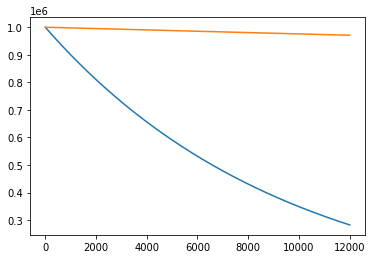

In [1]:
import math
import matplotlib.pyplot as mpl

# Times in seconds
def ActivityAtTime( StartingActivity, TimeElapsed, HalfLife ):
    return StartingActivity * ( 2.0 ** ( -TimeElapsed / HalfLife ) )

def F18ActivityAtTime( StartingActivity, TimeElapsed ):
    return ActivityAtTime( StartingActivity, TimeElapsed, 109.77*60.0 )

def Zr89ActivityAtTime( StartingActivity, TimeElapsed ):
    return ActivityAtTime( StartingActivity, TimeElapsed, 78.41*60.0*60.0 )

def ActivityPlot( StartingActivity, EndTime, ActivityMethod ):
    activityValues = []
    timeValues = []
    time = 0.0
    while time < EndTime:
        activityValues.append( ActivityMethod( StartingActivity, time ) )
        timeValues.append( time )
        time += 1.0
        
    mpl.plot( timeValues, activityValues )
    
ActivityPlot( 1E6, 200.0*60.0, F18ActivityAtTime )
ActivityPlot( 1E6, 200.0*60.0, Zr89ActivityAtTime )
mpl.show()

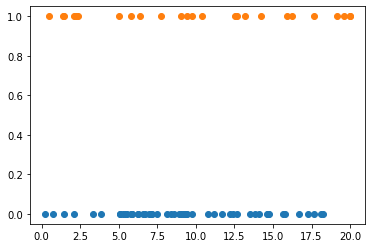

In [2]:
import random

# Simulate poisson-distributed random decay times
# Based on example https://timeseriesreasoning.com/contents/poisson-process/
def DeltaT( DecayRate ):
    randUniform = random.random()
    return -math.log( 1.0 - randUniform ) / DecayRate

def ActivityTimeline( DecayRate, EndTime ):
    decayTimes = []
    time = 0.0
    while time < EndTime:
        time += DeltaT( DecayRate )
        if time < EndTime:
            decayTimes.append( time )
            
    return decayTimes
            
def TimelinesPlot( Timelines ):
    for i, decayTimes in enumerate( Timelines ):
        dummyY = []
        for time in decayTimes:
            dummyY.append( i )
            
        mpl.scatter( decayTimes, dummyY )

TimelinesPlot( [ ActivityTimeline( 2, 20 ), ActivityTimeline( 1, 20 ) ] )
mpl.show()

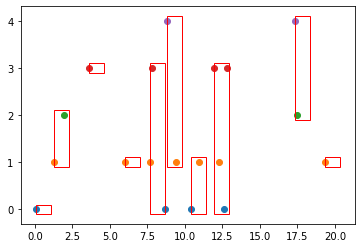

[[0], [1, 2], [3], [1], [0, 1, 3], [1, 4], [0, 1], [0, 1, 3, 3], [2, 4], [1]]


In [3]:
import sys
from matplotlib.patches import Rectangle

def FindCoincidences( Timelines, TimeWindow ):
    coincidences = []
    coincidenceTimes = []
    
    # Find the first event in each timeline
    nextTimes = []
    nextIndices = []
    for decayTimes in Timelines:
        if len( decayTimes ) == 0:
            nextTimes.append( sys.float_info.max )
        else:
            nextTimes.append( decayTimes[0] )
        nextIndices.append( 0 )
    
    unfinishedTimeline = True
    while unfinishedTimeline:

        # Start the window at the first unprocessed event
        time = min( nextTimes )
        #print( nextTimes, " min = ", time )
    
        # Find all events in the window
        coincidence = []
        for timelineIndex, nextTime in enumerate( nextTimes ):
            #print( "testing", timelineIndex, nextTime, " against ", time )
            if nextTime >= time and nextTime <= time + TimeWindow \
                and nextTime < sys.float_info.max - TimeWindow: # to catch the dummy values
                #print( "coincidence!" )
                coincidence.append( timelineIndex )
                
        # Catch a no-coincidence (including self) because we've ended up all infinities
        if len( coincidence ) == 0:
            break
    
        # Update to the next time for anything in the coincidence window
        unfinishedTimeline = False
        finalCoincidence = []
        for timelineIndex in coincidence:
            
            # Find the first time that's outside the current window
            nextIndex = nextIndices[ timelineIndex ]
            nextTime = Timelines[ timelineIndex ][ nextIndex ]
            while nextTime <= time + TimeWindow:
                
                # Add entries if there is coincidence within the window for a single timeline
                finalCoincidence.append( timelineIndex )
                nextIndex += 1
            
                # Test for reaching the end of the timeline
                if nextIndex >= len( Timelines[ timelineIndex ] ):
                    nextTimes[ timelineIndex ] = sys.float_info.max
                    nextIndices[ timelineIndex ] = -1
                    break
                else:
                    nextTime = Timelines[ timelineIndex ][ nextIndex ]
                    nextTimes[ timelineIndex ] = nextTime
                    nextIndices[ timelineIndex ] = nextIndex
                    unfinishedTimeline = True
        
        # Need to search for dummy indices since we don't update everything each round
        for nextIndex in nextIndices:
            if nextIndex > -1:
                unfinishedTimeline = True
                break
                
        coincidences.append( finalCoincidence )
        coincidenceTimes.append( time )
    
    return coincidences, coincidenceTimes

def CoincidenceBoxes( Coincidences, CoincidenceTimes, TimeWindow ):
    
    for i, coincidence in enumerate( Coincidences ):
        time = CoincidenceTimes[ i ]
        y = min( coincidence )
        height = max( coincidence ) - y
        y -= 0.1
        height += 0.2
        mpl.gca().add_patch( Rectangle( (time, y), TimeWindow, height, \
                                        linewidth=1,edgecolor='r',facecolor='none') )
        
exampleTimelines = [ ActivityTimeline( 0.2, 20 ), ActivityTimeline( 0.2, 20 ), ActivityTimeline( 0.2, 20 ), ActivityTimeline( 0.2, 20 ), ActivityTimeline( 0.2, 20 ) ]
coincidences, coincidenceTimes = FindCoincidences( exampleTimelines, 1 )
TimelinesPlot( exampleTimelines )
CoincidenceBoxes( coincidences, coincidenceTimes, 1 )
mpl.show()

print( coincidences )

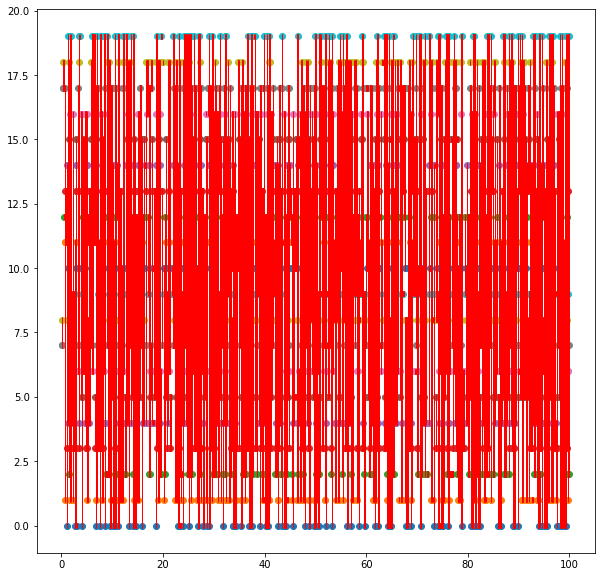

In [4]:
# Large test for performance
largeTimelineSet = []
for i in range( 20 ):
    largeTimelineSet.append( ActivityTimeline( 1, 100 ) )
coincidences, coincidenceTimes = FindCoincidences( largeTimelineSet, 0.1 )
TimelinesPlot( largeTimelineSet )
CoincidenceBoxes( coincidences, coincidenceTimes, 0.1 )

mpl.gcf().set_size_inches(10, 10)
mpl.show()

#print( coincidences )

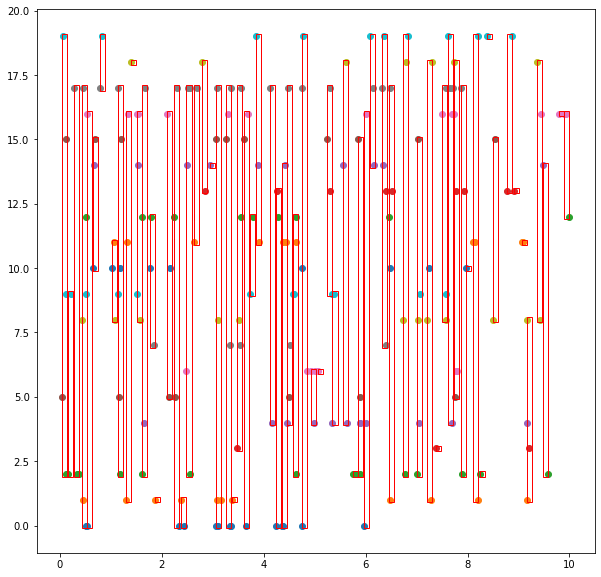

[[2, 5, 9, 15, 19], [2, 9], [2, 2, 17], [0, 1, 8, 9, 12, 17], [0, 16], [10, 14, 15], [17, 19], [8, 10, 11], [2, 5, 9, 10, 15, 17], [1, 11, 16], [18], [8, 9, 14, 16, 16], [2, 4, 12, 17], [7, 10, 12], [1], [5, 10, 16], [0, 5, 12, 17], [0, 1], [2, 6, 14, 17, 17], [11, 17], [13, 18], [14], [0, 0, 1, 1, 8, 15, 17], [0, 0, 7, 15, 16, 17], [1], [3, 7, 8, 12, 17], [0, 15, 16], [9, 12], [11, 14, 19], [4, 17], [0, 12, 13], [0, 0, 11, 11, 14], [4, 5, 7, 17], [2, 9, 9, 11, 12], [0, 6, 10, 17, 19], [4, 6, 6], [6], [9, 13, 15, 17], [4, 9], [4, 14, 18], [2, 2], [2, 4, 4, 5, 15], [0, 4, 16], [14, 17, 19], [7, 13, 14, 17, 19], [1, 10, 12, 13, 17], [2, 8, 18, 19], [2, 4, 8, 9, 15], [1, 8, 10, 18], [3], [8, 9, 16, 17], [4, 16, 17, 17, 19], [5, 6, 6, 13, 16, 18], [2, 13, 17], [10], [1, 11, 11, 19], [2], [19], [8, 15], [13, 19], [13], [11, 11], [1, 3, 4, 8], [8, 16, 18], [2, 14], [16], [12, 16, 16]]


In [5]:
# Avoid pre-generating timelines since it blows up the RAM
def GenerateCoincidences( DecayRates, EndTime, TimeWindow, TimelinesOut = None ):
    coincidences = []
    coincidenceTimes = []
    
    # Set the first event in each timeline
    nextTimes = []
    for channel in range( len( DecayRates ) ):
        nextTimes.append( DeltaT( DecayRates[ channel ] ) )
        if TimelinesOut is not None:
            TimelinesOut.append( [] )
    
    unfinishedTimeline = True
    while unfinishedTimeline:

        # Check if we have anything to process
        unfinishedTimeline = False
        for nextTime in nextTimes:
            if nextTime <= EndTime:
                unfinishedTimeline = True
                break
        
        # Start the window at the earliest event
        time = min( nextTimes )
        #print( nextTimes, " min = ", time )
    
        # Find all events in the window
        coincidence = []
        for channelIndex, nextTime in enumerate( nextTimes ):
            
            while nextTime <= time + TimeWindow and nextTime <= EndTime:
                
                # Store the time point
                coincidence.append( channelIndex )
                if TimelinesOut is not None:
                    TimelinesOut[ channelIndex ].append( nextTime )
                    
                # Update to next time point
                nextTime += DeltaT( DecayRates[ channelIndex ] )
                
            # Store the first event outside the window, for the next coincidence
            nextTimes[ channelIndex ] = nextTime
        
        # The last entry is empty, because all times now past end
        if len( coincidence ) > 0:
            #print( coincidence )    
            coincidences.append( coincidence )
            if TimelinesOut is not None:
                coincidenceTimes.append( time )
    
    return coincidences, coincidenceTimes

quickTimelines = []
coincidences, coincidenceTimes = GenerateCoincidences( 20 * [1.0], 10.0, 0.1, quickTimelines )
TimelinesPlot( quickTimelines )
CoincidenceBoxes( coincidences, coincidenceTimes, 0.1 )

mpl.gcf().set_size_inches(10, 10)
mpl.show()

print( coincidences )

In [6]:
%%time

# Get summaries from a large set
coincidences, coincidenceTimes = GenerateCoincidences( 2000*[60.0], 1.0, 1E-9 )
print( "Number of coincidences: ", len( coincidences ) )
eventsPerCoincidence = 0
for coincidence in coincidences:
    eventsPerCoincidence += len( coincidence )
print( "Average coincidence size: ", eventsPerCoincidence / len( coincidences ) )

Number of coincidences:  120150
Average coincidence size:  1.0000915522263838
CPU times: user 18.7 s, sys: 18.2 ms, total: 18.7 s
Wall time: 18.7 s


In [7]:
%%time

# Not viable to work with each crystal separately - do whole detector as bulk
import SiemensQuadraProperties as sqp

print( sqp.Lu176decaysInMass( sqp.CrystalMass() ) )
print( sqp.Lu176decaysInMass( sqp.DetectorMass() ) )

# from the paper, 894 MBq of F18, 4.7ns coincidence window
coincidences, coincidenceTimes = GenerateCoincidences( [894E6, sqp.Lu176decaysInMass( sqp.DetectorMass() )], 1E-3, 4.7E-9 )
print( "Number of coincidences: ", len( coincidences ) )
eventsPerCoincidence = 0
crystalEventsPerCoincidence = 0
for coincidence in coincidences:
    eventsPerCoincidence += len( coincidence )
    crystalEventsPerCoincidence += sum( coincidence )
print( "Average coincidence size: ", eventsPerCoincidence / len( coincidences ) )
print( "Average crystal activity per coincidence: ", crystalEventsPerCoincidence / len( coincidences ) )

60.55101147199834
14726005.989989998
Number of coincidences:  172556
Average coincidence size:  5.269947147592665
Average crystal activity per coincidence:  0.08534620644892094
CPU times: user 528 ms, sys: 8.15 ms, total: 536 ms
Wall time: 533 ms


In [8]:
from SimulationDataset import *

# from the paper energy window 435 keV, 585 keV
crystalData = SimulationDataset( "../crystalRadioactivity.log", 1000000, 435.0, 585.0 )
tracerData = SimulationDataset( "../linearF18.log", 1000000, 435.0, 585.0 )

print( crystalData.SampleOneEvent() )

5 15309 473.403 7.64923e-10 418.681 -8.81237e-06 -420.291
 5 [15309, 473.403, 7.64923e-10, 418.681, -8.81237e-06, -420.291]
249016.0 events loaded (1000000 expected) with average 1.0071119928036754 hits/event
0 161114 510.999 1.38211 414.23 1.16612 172.959
 0 [161114, 510.999, 1.38211, 414.23, 1.16612, 172.959]
234043.0 events loaded (1000000 expected) with average 1.0889964664612912 hits/event
[[83702, 533.492, 6.78768e-10, 411.521, -2.21451e-05, -153.248]]


In [9]:
trueEvents = 0
allEvents = 0

for coincidence in coincidences:
    event = []
    for source in coincidence:
        if source == 0:
            event += tracerData.SampleOneEvent()
        else:
            event += crystalData.SampleOneEvent()
    
    if TwoHitEvent( event ):
        allEvents += 1
        if BackToBackEvent( event, 0.1 ):
            trueEvents += 1
            
print( "true events: ", trueEvents )
print( "all events: ", allEvents )
print( "NECR: ", trueEvents * trueEvents / allEvents )

true events:  5016
all events:  37902
NECR:  663.8239670729777


In [10]:
# Work out the behaviour at the end of one of their 240s runs
coincidences, coincidenceTimes = GenerateCoincidences( [F18ActivityAtTime(894E6,240), sqp.Lu176decaysInMass( sqp.DetectorMass() )], 1E-3, 4.7E-9 )

trueEventsEnd = 0
allEventsEnd = 0

for coincidence in coincidences:
    event = []
    for source in coincidence:
        if source == 0:
            event += tracerData.SampleOneEvent()
        else:
            event += crystalData.SampleOneEvent()
    
    if TwoHitEvent( event ):
        allEventsEnd += 1
        if BackToBackEvent( event, 0.1 ):
            trueEventsEnd += 1
            
print( "true events/msec: ", trueEventsEnd )
print( "all events/msec: ", allEventsEnd )
print( "NECR/msec: ", trueEventsEnd * trueEventsEnd / allEventsEnd )

true events/msec:  5132
all events/msec:  37722
NECR/msec:  698.197974656699


In [11]:
# Do a (simple, linear) interpolation
averageTrue = (trueEvents + trueEventsEnd)/2.0
averageAll = (allEvents + allEventsEnd)/2.0

# 1s
sumTrue = averageTrue / 1E-3
sumAll = averageAll / 1E-3

# final NECR
print( "NECR/sec: ", sumTrue * sumTrue / sumAll )

# whole 240s
sumTrue = averageTrue * 240.0 / 1E-3
sumAll = averageAll * 240.0 / 1E-3

# final NECR
print( "NECR/240sec: ", sumTrue * sumTrue / sumAll )

# Paper says O(10^6) cps, i.e. I'm 100x too big... (or 10x too small)

NECR/sec:  680881.0959483762
NECR/240sec:  163411463.02761027


In [24]:
# Try estimating "true" coincidences from background only, like other paper
# They say 600cps I might be 4x higher due to fov
# 350 - 650 keV window
coincidences, coincidenceTimes = GenerateCoincidences( [sqp.Lu176decaysInMass( sqp.DetectorMass() )], 1, 4.7E-9 )

crystalNoPhantomData = SimulationDataset( "../crystalRadioactivity.noPhantom.10mil.log", 10000000, 350.0, 650.0 )

# just try the whole file
allInFile = 0
trueInFile = 0
for i in range(10000000):
    event = crystalNoPhantomData.SampleOneEvent()
    if TwoHitEvent( event ):
        allInFile += 1
        if BackToBackEvent( event , 0.1 ):
            trueInFile += 1

print( "true coincidence events in file ", allInFile )
print( "back-to-back events in file ", trueInFile )

allEventsBackground = 0
trueEventsBackground = 0
for coincidence in coincidences:
    event = []
    for source in coincidence:
        event += crystalNoPhantomData.SampleOneEvent()
    
    if TwoHitEvent( event ):
        allEventsBackground += 1
        if BackToBackEvent( event, 0.1 ):
            trueEventsBackground += 1
            
print( "coincidence events in 1 sec: ", allEventsBackground )           
print( "back-to-back events in 1 sec: ", trueEventsBackground )

0 53304 407.698 8.882e-10 410.94 6.8751e-06 -273.776
 0 [53304, 407.698, 8.882e-10, 410.94, 6.8751e-06, -273.776]
5068541.0 events loaded (10000000 expected) with average 1.0155145238047794 hits/event
true coincidence events in file  78624
back-to-back events in file  0
coincidence events in 1 sec:  341207
back-to-back events in 1 sec:  0


In [13]:
# not getting very far, try another way
# seems the capilary is 5 ml, and there's a plot in terms of activity (kBq) per mL
# they say 8633k true events/sec @ 27.49 kBq/ml
coincidences, coincidenceTimes = GenerateCoincidences( [F18ActivityAtTime(150E3,240), sqp.Lu176decaysInMass( sqp.DetectorMass() )], 1, 4.7E-9 )

trueEventsEnd = 0
allEventsEnd = 0

for coincidence in coincidences:
    event = []
    for source in coincidence:
        if source == 0:
            event += tracerData.SampleOneEvent()
        else:
            event += crystalData.SampleOneEvent()
    
    if TwoHitEvent( event ):
        allEventsEnd += 1
        if BackToBackEvent( event, 0.1 ):
            trueEventsEnd += 1
            
print( "true events/sec: ", trueEventsEnd )
print( "all events/sec: ", allEventsEnd )
print( "NECR/sec: ", trueEventsEnd * trueEventsEnd / allEventsEnd )

# whole 240s
sumTrue = trueEventsEnd * 240.0
sumAll = allEventsEnd * 240.0

# final NECR
print( "NECR/240sec: ", sumTrue * sumTrue / sumAll )

true events/sec:  2160
all events/sec:  87845
NECR/sec:  53.111730889635155
NECR/240sec:  12746.815413512437


In [14]:
#test basic thing from paper
print( F18ActivityAtTime( 740E6, 14.3*60.0*60.0 ) / 5.0 )

656610.6714862306


In [15]:
#Try and work out the scatter rate
allSignal = 0
trueSignal = 0
for i in range( 1000000 ):
    event = tracerData.SampleOneEvent()
    if TwoHitEvent( event ):
        allSignal += 1
        if BackToBackEvent( event, 0.1 ):
            trueSignal += 1
            
print( "scatterRatio: ", 1- trueSignal/allSignal )

scatterRatio:  0.27202991657877074


In [16]:
#Try and reproduce the plot versus activity
#sampling every 20mins for 700mins
trueAtTime = []
allAtTime = []
necrAtTime = []
activityAtTime = []
times = []
for time in range( 0, 700, 20 ):
    timeSec = float(time) * 60.0
    activity = F18ActivityAtTime( 894E6, timeSec )
    
    # generate 10ms of coincidences
    coincidences, coincidenceTimes = GenerateCoincidences( [activity, sqp.Lu176decaysInMass( sqp.DetectorMass() )], 1E-2, 4.7E-9 )

    # classify the coincidences
    trueEvents = 0
    allEvents = 0
    for coincidence in coincidences:
        event = []
        for source in coincidence:
            if source == 0:
                event += tracerData.SampleOneEvent()
            else:
                event += crystalData.SampleOneEvent()
    
        if TwoHitEvent( event ):
            allEvents += 1
            if BackToBackEvent( event, 0.1 ):
                trueEvents += 1
                
    allAtTime.append( allEvents / 1E-2 )
    trueAtTime.append( trueEvents / 1E-2 )
    necrAtTime.append( trueEvents * trueEvents * 1E2 / allEvents )
    activityAtTime.append( activity )
    times.append( time )
    
#print("done")

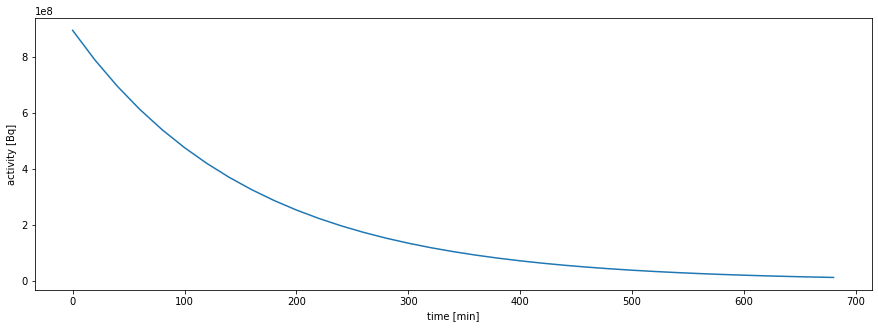

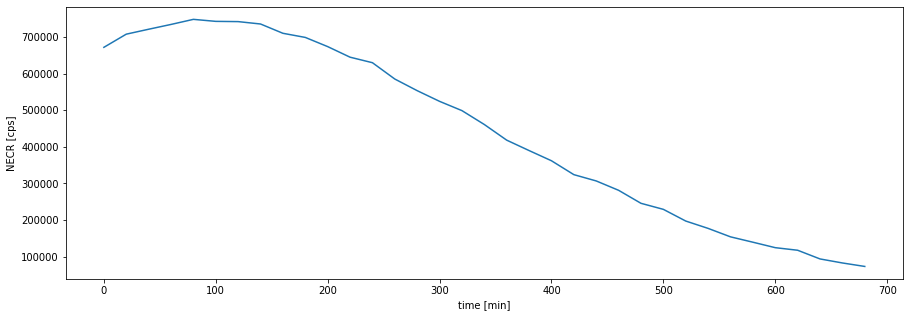

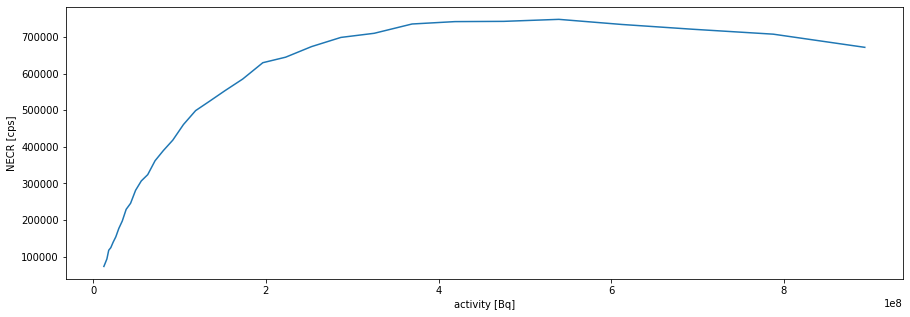

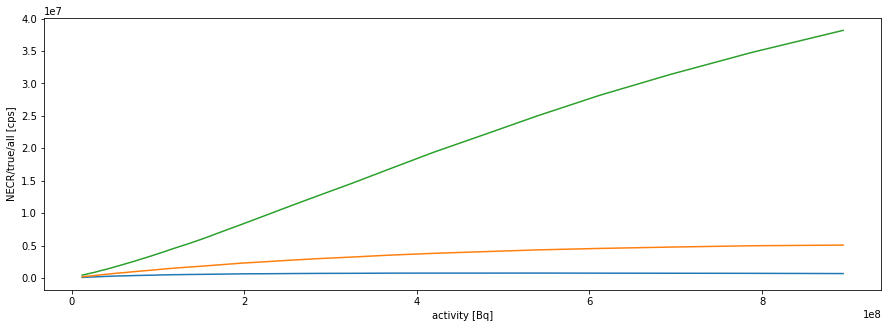

In [17]:
mpl.plot( times, activityAtTime )
mpl.gcf().set_size_inches(15, 5)
mpl.gca().set_xlabel("time [min]")
mpl.gca().set_ylabel("activity [Bq]")
mpl.show()
mpl.plot( times, necrAtTime )
mpl.gcf().set_size_inches(15, 5)
mpl.gca().set_xlabel("time [min]")
mpl.gca().set_ylabel("NECR [cps]")
mpl.show()
mpl.plot( activityAtTime, necrAtTime )
#errorLow = [ x - math.sqrt(x/1000) for x in necrAtTime ]
#errorHigh = [ x + math.sqrt(x/1000) for x in necrAtTime ]
#print( errorHigh[0] )
#print( errorLow[0] )
#mpl.fill_between( activityAtTime, errorLow, errorHigh )
mpl.gcf().set_size_inches(15, 5)
mpl.gca().set_xlabel("activity [Bq]")
mpl.gca().set_ylabel("NECR [cps]")
mpl.show()
mpl.plot( activityAtTime, necrAtTime )
mpl.plot( activityAtTime, trueAtTime )
mpl.plot( activityAtTime, allAtTime )
mpl.gcf().set_size_inches(15, 5)
mpl.gca().set_xlabel("activity [Bq]")
mpl.gca().set_ylabel("NECR/true/all [cps]")
mpl.show()

In [18]:
# am I going insane? calculate the capillary volume
# "A 3 mm wide and 70 cm long polyethylene capillary was filled with 894 MBq 18 F"
areaM2 = ((0.003/2.0)**2) * math.pi
volumeM3 = areaM2*0.7
volumeML = volumeM3*1E6
print( volumeML )

4.948008429403924


In [19]:
# OK, try the plot again assuming their activity numbers, not the starting activity
#sampling every 20mins for 700mins
trueAtTime = []
allAtTime = []
necrAtTime = []
activityAtTime = []
times = []
for time in range( 0, 700, 20 ):
    timeSec = float(time) * 60.0
    activity = F18ActivityAtTime( 200E3, timeSec )
    
    # generate 100ms of coincidences
    coincidences, coincidenceTimes = GenerateCoincidences( [activity, sqp.Lu176decaysInMass( sqp.DetectorMass() )], 1E-1, 4.7E-9 )

    # classify the coincidences
    trueEvents = 0
    allEvents = 0
    for coincidence in coincidences:
        event = []
        for source in coincidence:
            if source == 0:
                event += tracerData.SampleOneEvent()
            else:
                event += crystalData.SampleOneEvent()
    
        if TwoHitEvent( event ):
            allEvents += 1
            if BackToBackEvent( event, 0.1 ):
                trueEvents += 1
                
    allAtTime.append( allEvents / 1E-1 )
    trueAtTime.append( trueEvents / 1E-1 )
    necrAtTime.append( trueEvents * trueEvents * 1E1 / allEvents )
    activityAtTime.append( activity )
    times.append( time )

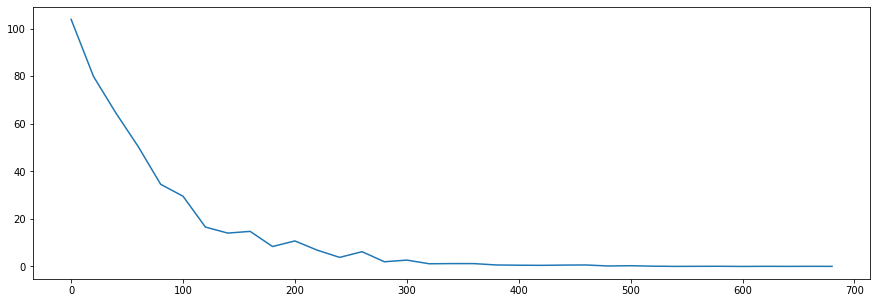

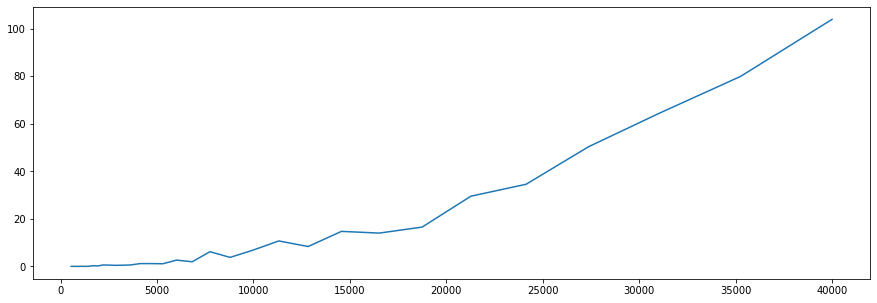

In [20]:
mpl.plot( times, necrAtTime )
mpl.gcf().set_size_inches(15, 5)
mpl.show()
mpl.plot( [x/5 for x in activityAtTime], necrAtTime )
mpl.gcf().set_size_inches(15, 5)
mpl.show()

In [21]:
# figure out the right angular tolerance
# "trues are the integral of the counts above a linearly interpolated background within a 2-cm radius"
# 
dPhi = math.atan2( 2.0, 41.0 )
print(dPhi)
# accidentally got it about right :P
# hmm, actually no I didn't, geometry is wrong
dPhi = math.atan2( 2.0*2.0, 41.0 )
print(dPhi)

0.04874185130993159
0.09725319825156577
